In [1]:
!pip install -U datasets #>=1.18.3
!pip install -U transformers #==4.17.0
!pip install -U evaluate
!pip install -U librosa
!pip install -U seaborn
!pip install -U jiwer

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached safetensors-0.5.3.tar.gz (67 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Checking for Rust toolchain....
      
      Cargo, the Rust package manager, is not installed or is not on PATH.
      This package requires Rust and Cargo to compile extensions. Install it through
      the system's package manager or via https://rustup.rs/
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

WANDB_KEY = user_secrets.get_secret("wandb_key")

In [6]:
# from huggingface_hub import notebook_login
# notebook_login()

# Dataset

In [3]:
import json
from datasets import Dataset, DatasetDict, Audio, load_dataset
from tqdm.auto import tqdm
import random

import os
import numpy as np
import pandas as pd
import torchaudio

## Let's load dataset

In [4]:
DATA_PATH = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/'
DATA_SPLIT = '/kaggle/input/timit-data-split/TIMIT_DATA_SPLIT.json'

In [5]:
with open(DATA_SPLIT, "r") as f:
    dataset = json.load(f)

dataset.keys()

dict_keys(['train', 'valid', 'test'])

### How many hours are in each set?
At least this helps us understand how big/small our dataset is.

In [10]:
# import librosa

# def get_durations(dict_data):
#     total_durations = 0

#     for entry in dict_data.values():
#         audio_data, _ = librosa.load(entry['audio_file'], sr=16_000)
#         duration = len(audio_data) / 16_000
#         total_durations += duration

#     return int(total_durations)

In [11]:
# print(f"Duration of Train: {get_durations(dataset['train']) // 60} mns")
# print(f"Duration of Valid: {get_durations(dataset['valid']) // 60} mns")
# print(f"Duration of Test : {get_durations(dataset['test']) // 60} mns")

# Preprocessing

## Process into HuggingFace Dataset Format

In [12]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])
    
    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [13]:
train = convert_to_feature_dict(dataset['train'])
valid = convert_to_feature_dict(dataset['valid'])
test  = convert_to_feature_dict(dataset['test'])

In [14]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [15]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 1440
})


## Read files for phonetics

In [16]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)
    
def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

In [ ]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

## Normalize the Phonetics

As we can see the result below, there are *61* phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

In [18]:
train_dataset

Dataset({
    features: ['audio_file', 'text', 'phonetic'],
    num_rows: 1440
})

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [20]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [ ]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Phonetic Distribution
Let's check the distribution of each phone across all three test set. Note that we don't do simple counting. Instead, for each phoneme, we show the ratio of that phoneme relative to that specific set. On test set, obviously, the count of each phoneme is less than the train, but the ratio should be similar to the training set.

In [23]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [24]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [25]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

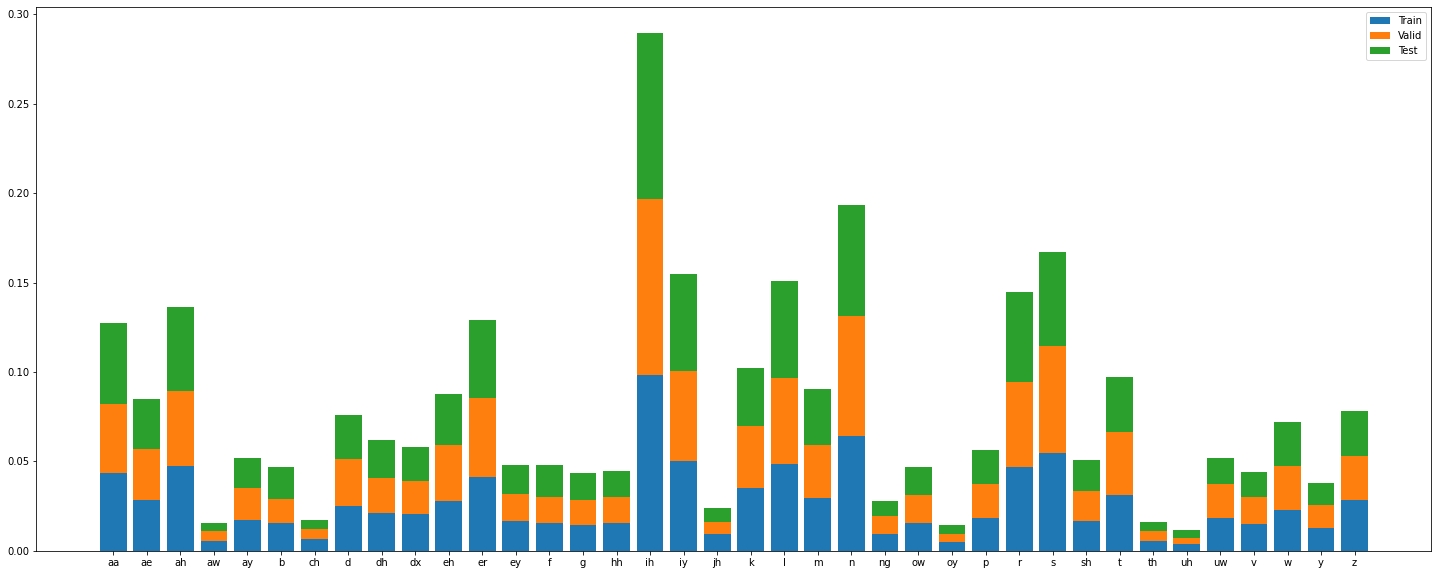

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio, label="Train")
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio, label="Valid")
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)], label="Test")

plt.legend()

plt.show()

## Load Audio File

In [27]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [ ]:
train_dataset[0]

{'audio': {'path': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR3/FALK0/SA1.WAV',
  'array': array([-9.15527344e-05,  2.74658203e-04,  1.22070312e-04, ...,
         -9.15527344e-05, -2.74658203e-04,  1.22070312e-04]),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh eh h# d y er h# d aa r h# k s uw h# h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: thus far the advances made have been almost entirely along functional lines
Phonetics: h# dh ah s f aa r dh iy ih h# v ae n s ah z m ey h# d ih h# b ih n aa l m ah s h# t ih n h# t ay er l iy ih l aa ng f ah ng k sh h# n l l ay n s h#
Input array shape: (65332,)
Sampling rate: 16000


## Build Character Set

In [30]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [31]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [32]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [33]:
# save vocab.json
import json
with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

# Modeling

## Input Processor

In [34]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from tokenizers.processors import TemplateProcessing

In [35]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("/kaggle/working/", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )  # './' load vocab.json in the current directory
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)  
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
# This does not prepare the input for the Transformer model.
# This will resample the data and convert the sentence into indices
# Batch here is just for one entry (row)
def prepare_dataset(batch):
    audio = batch["audio"]
    
    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

In [ ]:
# train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
# valid_dataset = valid_dataset.map(prepare_dataset, remove_columns=valid_dataset.column_names)
# test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)
train_dataset = train_dataset.map(prepare_dataset)
valid_dataset = valid_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [38]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

## Evaluation Metrics

We use WER (Word Error Rate) and CER (Character Error Rate) to measure the performance of our model. After the training, we realize that WER may not be the right fit. CER fits better.

Note that CER here has some errors in our use case because each ARPAbet token is represented by one to three characters. For example, a label token is "ch" and another is "ae", that's two character error right there.

After the training, we will re-evaluate on test-set one more time, which we will evaluate at token level.

In [ ]:
from evaluate import load

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
# wer_metric = load_metric("wer")
cer_metric = load("cer")

In [40]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids)
    label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)
    
    #wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    print("Predicted sample", pred_str[0])
    print("GT sample", label_str[0])

    return {
        #"wer": wer,
        "cer": cer
    }

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
#     mask_time_prob=0.75, 
#     mask_time_length=10,
#     mask_feature_prob=0.25,
#     mask_feature_length=64,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.bias', 'project_q.weight', 'project_hid.weight', 'project_q.bias', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [42]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

In [43]:
# model.freeze_feature_encoder()

## Training

In [ ]:
import wandb
wandb.login(key=WANDB_KEY)

os.environ["WANDB_LOG_MODEL"] = "checkpoint"

# Initialize with team/entity
wandb.init(
    project="iasa-ucu-audio-processing",
    entity="BashHav", 
    name='wav2vec_test',
    settings=wandb.Settings(init_timeout=180) 
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ivanbashtovyi1 (IASA-BA-Diploma-Ivan-Bashtovyi). Use `wandb login --relogin` to force relogin


In [45]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    group_by_length=True,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    fp16=True,
    report_to='wandb',
    max_steps=2000,
    save_steps=100,
    eval_steps=100,
    logging_steps=20,
    learning_rate=1e-4,
    warmup_steps=20,
    save_total_limit=3,
    load_best_model_at_end=True
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor.feature_extractor
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


In [47]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1440
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 300
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Cer
100,3.333300,3.306971,1.000000
200,3.133200,3.092473,0.729807
300,2.910700,2.816512,0.725933


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 240
  Batch size = 8


Predicted sample 
GT sample h#shiyhhaeh#jherh#daarh#k suwh#th#ihnh#g riysiywaashh#waadxerh#aal yiherh#


Saving model checkpoint to /kaggle/working/checkpoint-100
Configuration saved in /kaggle/working/checkpoint-100/config.json
Model weights saved in /kaggle/working/checkpoint-100/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-100/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 240
  Batch size = 8


Predicted sample h#h#h#h#h#h#h#h#h#h#h#h#
GT sample h#shiyhhaeh#jherh#daarh#k suwh#th#ihnh#g riysiywaashh#waadxerh#aal yiherh#


Saving model checkpoint to /kaggle/working/checkpoint-200
Configuration saved in /kaggle/working/checkpoint-200/config.json
Model weights saved in /kaggle/working/checkpoint-200/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-200/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 240
  Batch size = 8


Predicted sample h#h#kh#kh#kh#kh#h#kh#h#h#h#
GT sample h#shiyhhaeh#jherh#daarh#k suwh#th#ihnh#g riysiywaashh#waadxerh#aal yiherh#


Saving model checkpoint to /kaggle/working/checkpoint-300
Configuration saved in /kaggle/working/checkpoint-300/config.json
Model weights saved in /kaggle/working/checkpoint-300/pytorch_model.bin
Feature extractor saved in /kaggle/working/checkpoint-300/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /kaggle/working/checkpoint-300 (score: 2.8165123462677).


TrainOutput(global_step=300, training_loss=3.7954271697998045, metrics={'train_runtime': 623.2749, 'train_samples_per_second': 7.701, 'train_steps_per_second': 0.481, 'total_flos': 4.7240475528876096e+17, 'train_loss': 3.7954271697998045, 'epoch': 3.33})

## Evaluate on Test Set

In [48]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8


Predicted sample h#h#kh#kh#kh#h#h#h#h#
GT sample h#shiyhhaeh#d yerh#daarh#k suwdxihngh#g riysiywaashh#waadxerh#aal yiyerh#


{'eval_loss': 2.835930585861206,
 'eval_cer': 0.7327310734775442,
 'eval_runtime': 99.1109,
 'eval_samples_per_second': 16.951,
 'eval_steps_per_second': 2.119,
 'epoch': 3.33}

In [49]:
# trainer.evaluate(train_dataset)

## Save Model

In [50]:
# save locally
# trainer.save_model()

In [51]:
# trainer.push_to_hub(repo_name="vitouphy/wav2vec2-xls-r-300m-phoneme")

In [52]:
# tokenizer.push_to_hub('vitouphy/xls-r-300m-km')
# model.push_to_hub(repo_path_or_name='vitouphy/wav2vec2-xls-r-300m-phoneme')